In [1]:
import SimpleITK as sitk

import sys; sys.path.append("../src/readii")
from process.images.crop import crop_and_resize_image_and_mask
from image_processing import displayImageSlice

from imgtools.io import read_dicom_series
from rich import print as rprint

from readii.loaders import loadRTSTRUCTSITK

from readii.image_processing import displayImageSlice

import matplotlib.pyplot as plt

import numpy as np

In [74]:
sample = "RADCURE-0020" #"4D-Lung-113_HM10395"

match sample:
    case "RADCURE-0020":
        ct_path = "/Users/katyscott/Documents/READII-2-ROQC/readii-fmcib/archive/temp_complete_output/procdata/RADCURE/images/mit_outputs/0_RADCURE-0020/CT/CT.nii.gz"
        mask_path = "/Users/katyscott/Documents/READII-2-ROQC/readii-fmcib/archive/temp_complete_output/procdata/RADCURE/images/mit_outputs/0_RADCURE-0020/RTSTRUCT_CT/GTV.nii.gz"

        image = sitk.ReadImage(ct_path)
        mask = sitk.ReadImage(mask_path)
    
    case "4D-Lung-113_HM10395":
        image = read_dicom_series("../tests/4D-Lung/113_HM10395/11-26-1999-NA-p4-13296/1.000000-P4P113S303I10349 Gated 40.0B-29543")

        rois = loadRTSTRUCTSITK(rtstructPath = "../tests/4D-Lung/113_HM10395/11-26-1999-NA-p4-13296/1.000000-P4P113S303I10349 Gated 40.0B-47.35/1-1.dcm",
                                baseImageDirPath = "../tests/4D-Lung/113_HM10395/11-26-1999-NA-p4-13296/1.000000-P4P113S303I10349 Gated 40.0B-29543",
                                roiNames = "Tumor_c.*")
        mask = rois["Tumor_c40"]

In [75]:
resize_dimension = 30

bbox_image, bbox_mask = crop_and_resize_image_and_mask(image, mask, crop_method = "bounding_box", resize_dimension=resize_dimension)
print(f"Bounding box: {bbox_image.GetSize()}")
print(f"Bounding box mask: {bbox_mask.GetSize()}")

centroid_image, centroid_mask = crop_and_resize_image_and_mask(image, mask, crop_method = "centroid", resize_dimension=resize_dimension)
print(f"Centroid: {centroid_image.GetSize()}")
print(f"Centroid mask: {centroid_mask.GetSize()}")

cube_image, cube_mask = crop_and_resize_image_and_mask(image, mask, crop_method = "cube", resize_dimension=resize_dimension)
print(f"Cube: {cube_image.GetSize()}")
print(f"Cube mask: {cube_mask.GetSize()}")

Bounding box: (30, 30, 30)
Bounding box mask: (30, 30, 30)
Centroid: (30, 30, 30)
Centroid mask: (30, 30, 30)
Cube: (30, 30, 30)
Cube mask: (30, 30, 30)


Text(0.5, 0.01, 'RADCURE-0020 -- Resize: 30')

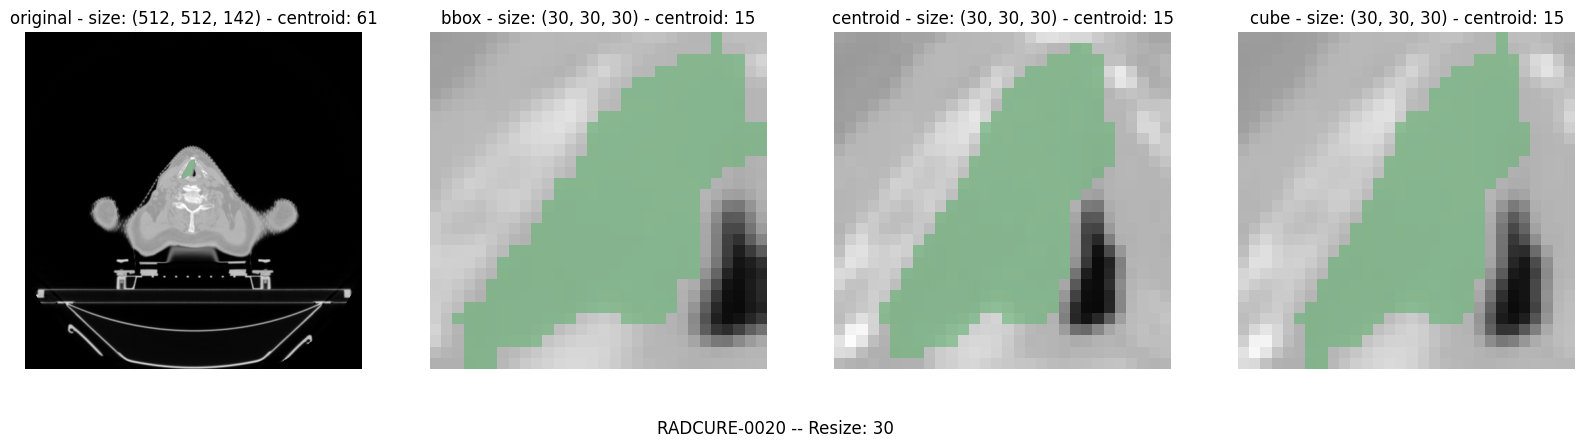

In [77]:
def plotSliceOnAxis(axis, img_slice, vmin, vmax, cmap=plt.cm.Greys_r):
    axis.imshow(img_slice, cmap=cmap, vmin=vmin, vmax=vmax)
    axis.set_axis_off()
    return axis


mage_type = "original"
figure, axis = plt.subplots(1,4)
figure.set_figwidth(20)
cmap=plt.cm.Greys_r
# range values taken from cube crop image
disp_min = -1000
disp_max = 755

crop_images = {"original": image,
               "bbox": bbox_image, 
               "centroid": centroid_image, 
               "cube": cube_image}

crop_masks = {"original": mask,
              "bbox": bbox_mask, 
              "centroid": centroid_mask, 
              "cube": cube_mask}


for idx, crop_type in enumerate(crop_images):
    selected_image = crop_images[crop_type]
    selected_mask = crop_masks[crop_type]

    
    # Get slice index from centroid of mask
    stats = sitk.LabelShapeStatisticsImageFilter()
    stats.Execute(selected_mask)
    centroid = stats.GetCentroid(1)
    centroid_idx = selected_mask.TransformPhysicalPointToIndex(centroid)
    
    # Get the image slice
    arr_image = sitk.GetArrayFromImage(selected_image)
    slice_idx = centroid_idx[2]
    img_slice = arr_image[slice_idx,:,:]
    
    # Plot the slice on the axis
    plotSliceOnAxis(axis[idx], img_slice=img_slice, vmin=disp_min, vmax=disp_max, cmap=cmap)

    # Plot the segmentation mask as overlay
    arr_mask = sitk.GetArrayFromImage(selected_mask)
    bin_mask = np.ma.masked_where(arr_mask==0, arr_mask) 

    axis[idx].imshow(bin_mask[slice_idx, :, :], cmap=plt.cm.Greens, vmin=disp_min, vmax=disp_max, alpha=0.5)
    axis[idx].set_title(f"{crop_type} - size: {selected_image.GetSize()} - centroid: {slice_idx}")

plt.figtext(0.5, 0.01, f"{sample} -- Resize: {resize_dimension}", horizontalalignment='center', fontsize=12)


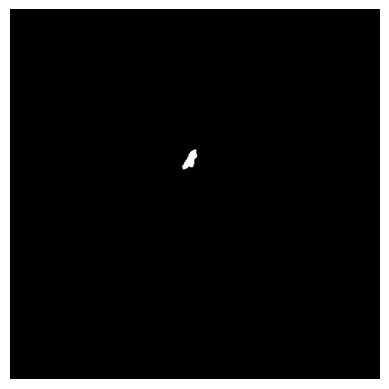

In [79]:
displayImageSlice(mask, sliceIdx = 61)

In [80]:
arr_mask = sitk.GetArrayFromImage(mask)
np.sum(np.nonzero(arr_mask))
arr_mask.shape

(142, 512, 512)

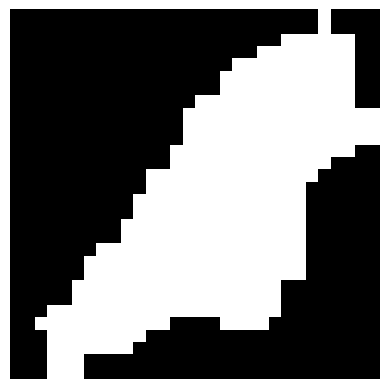

In [81]:
arr_bbox_mask = sitk.GetArrayFromImage(bbox_mask)

arr_converted_mask_round = np.round(arr_bbox_mask).astype(int)

arr_converted_mask_round.shape
displayImageSlice(arr_converted_mask_round, sliceIdx=15, sliceDim='first')



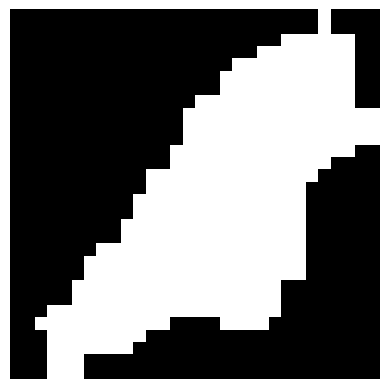

In [82]:
int_arr_bbox_mask = arr_bbox_mask.astype(int)

displayImageSlice(int_arr_bbox_mask, sliceIdx=15, sliceDim='first')

In [83]:
cast_mask = sitk.Cast(bbox_mask, sitk.sitkUInt8)

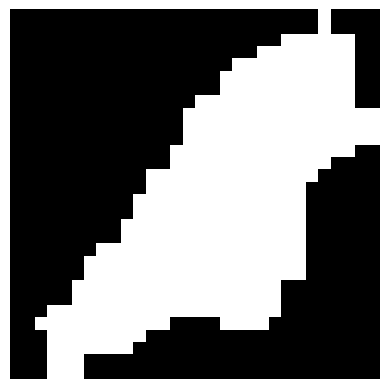

In [84]:
displayImageSlice(cast_mask, sliceIdx=15)

In [85]:
np.sum(arr_converted_mask_round[15,:,:])

364

In [86]:
np.sum(int_arr_bbox_mask[15,:,:])

364

In [87]:
np.sum(np.round(arr_bbox_mask[15,:,:], 2))

364

In [88]:
temp2 = np.where(arr_bbox_mask > 0.5, 1, 0)
np.sum(temp2[15,:,:])

364

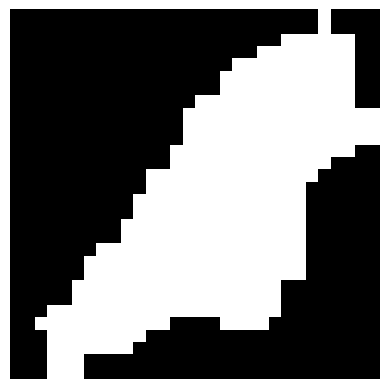

In [89]:
displayImageSlice(temp2, sliceIdx=15, sliceDim='first')